# Finding popular restaurants clusters in Chinatown, Washington 

Chinatown/Penn Quarter is one of Washington DC's most popular neighborhoods for dining because of its' central location and easy access to many of the city's biggest attractions including the Verizon Center, the National Portrait Gallery & American Art Museum and the International Spy Museum.  Chinatown is just a few blocks away and the Washington Convention Center is also within walking distance. The Gallery Place-Chinatown Metro station makes this area easily accessible from across the city. Restaurants in the area offer a wide range of cuisine from contemporary American to Asian Fusion, to Italian or Latin American fare. Chinatown has approximately 20 Chinese and Asian restaurants. 

To begin with I am importing all the necessary libraries and installing all the necessary packages. I will be primarity using Pandas, scikit learn, Matplotlib, Geocoders, Foursquare API, Folium

## Introduction

The purpose of this project is to anlayze the popular locality of Chinatown to understand the major restuarant types, their ratings as provided by foursquare users. 
This application is useful for any tourist who is visiting Pennsatate and is having trouble searching for places based on the prevalent popular cuisine of that place 

## Dataset used and Algorithm details

For this assignment, I will be using the Foursquare API to pull the following location data on restaurants in Chinatown, Washington:

Venue Name <br>
Venue ID <br>
Venue Location <br>
Venue Category <br>
Count of Likes <br>

For data acquisition I am using below methods:<br>
<br>
- Get geolocator lat and long coordinates for Chinatown, Washington <br>
- Use Foursquare API to get a list of all venues in Chinatown <br>
- Get venue name, venue ID, location, category, and likes <br>

After data acquisition using foursquare and geolocator, I will do preprocessing on data to remove the categories which are not Food Joints and then categorize them into 5 major food categories based on the data. I will then using histograms create bins to identify five categories of restaurant ratings based on user likes. I will then create a k-means clustering algorithm that will group restaurants into 5 clusters. 

## Step 1 - Import Libraries

In [122]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#import beautiful soup
from urllib.request import urlopen
print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


## Get Latitude and Longitude for chinatowns

In [197]:
address = 'Chinatown, Washington'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chinatown are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chinatown are 38.9003422, -77.0214430167629.


## Push Foursquare Request to get the Venues

In [198]:
CLIENT_ID = 'QL3NZKVSMYY302K4UWENOXDXQUTW1EL440H1GDZJH55DWSTA' # your Foursquare ID
CLIENT_SECRET = 'UQMBRSEF0LZZSIDRG43LQZJFXNXLTQ4AQIKMGJ1WV04CYTOH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QL3NZKVSMYY302K4UWENOXDXQUTW1EL440H1GDZJH55DWSTA
CLIENT_SECRET:UQMBRSEF0LZZSIDRG43LQZJFXNXLTQ4AQIKMGJ1WV04CYTOH


In [199]:
LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=QL3NZKVSMYY302K4UWENOXDXQUTW1EL440H1GDZJH55DWSTA&client_secret=UQMBRSEF0LZZSIDRG43LQZJFXNXLTQ4AQIKMGJ1WV04CYTOH&v=20180605&ll=38.9003422,-77.0214430167629&radius=500&limit=200'

In [201]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f09a6128a993d2972e04d06'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Chinatown',
  'headerFullLocation': 'Chinatown, Washington',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 115,
  'suggestedBounds': {'ne': {'lat': 38.9048422045, 'lng': -77.01567152474095},
   'sw': {'lat': 38.895842195499995, 'lng': -77.02721450878485}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '58dee3dc54386d4959b23de0',
       'name': 'Poké Papa',
       'location': {'address': '806 H St NW',
        'lat': 38.89951518,
        'lng': -77.02341047,
        'labeledLatLngs': [{'label': 'display',
       

In [202]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Get Venue Category

In [203]:
#pull the actual data from the Foursquare API

venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,venue.name,venue.id,venue.categories,venue.location.lat,venue.location.lng
0,Poké Papa,58dee3dc54386d4959b23de0,Poke Place,38.899515,-77.023410
1,SoulCycle Mount Vernon,55db1c30498e410a92af9ed0,Cycle Studio,38.901930,-77.020469
2,CAVA,54231977498eff43caedb3d5,Mediterranean Restaurant,38.899971,-77.022314
3,RPM Italian,575ae890498e04099a6d1c67,Italian Restaurant,38.902220,-77.020940
4,La Colombe Coffee Roasters,5648c247498e93b42e8897c8,Coffee Shop,38.901054,-77.020102
5,Sixth & I Historic Synagogue,4a9f0416f964a5203a3c20e3,Synagogue,38.900884,-77.020171
6,Nando's,4a4eb693f964a520f4ae1fe3,Portuguese Restaurant,38.900370,-77.021942
7,Dolcezza Gelato,552d5a73498e337582e351bf,Ice Cream Shop,38.900201,-77.024218
8,Taco Bamba,5ac710302b984427e9f885c7,Taco Place,38.901064,-77.022682
9,Chaia,5c34e803dab4b1002c5c4653,Taco Place,38.901015,-77.020934


In [204]:
#fix the column names so they look relatively normal

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues


,name,id,categories,lat,lng
0,Poké Papa,58dee3dc54386d4959b23de0,Poke Place,38.899515,-77.023410
1,SoulCycle Mount Vernon,55db1c30498e410a92af9ed0,Cycle Studio,38.901930,-77.020469
2,CAVA,54231977498eff43caedb3d5,Mediterranean Restaurant,38.899971,-77.022314
3,RPM Italian,575ae890498e04099a6d1c67,Italian Restaurant,38.902220,-77.020940
4,La Colombe Coffee Roasters,5648c247498e93b42e8897c8,Coffee Shop,38.901054,-77.020102
5,Sixth & I Historic Synagogue,4a9f0416f964a5203a3c20e3,Synagogue,38.900884,-77.020171
6,Nando's,4a4eb693f964a520f4ae1fe3,Portuguese Restaurant,38.900370,-77.021942
7,Dolcezza Gelato,552d5a73498e337582e351bf,Ice Cream Shop,38.900201,-77.024218
8,Taco Bamba,5ac710302b984427e9f885c7,Taco Place,38.901064,-77.022682
9,Chaia,5c34e803dab4b1002c5c4653,Taco Place,38.901015,-77.020934


## Get All categories of Venues

In [205]:
# find a list of unique categories from the API so we can see what may or may not fit for restaurants

nearby_venues['categories'].unique()

array(['Poke Place', 'Cycle Studio', 'Mediterranean Restaurant',
       'Italian Restaurant', 'Coffee Shop', 'Synagogue',
       'Portuguese Restaurant', 'Ice Cream Shop', 'Taco Place',
       'Asian Restaurant', 'Seafood Restaurant', 'Electronics Store',
       'Basketball Stadium', 'Vegetarian / Vegan Restaurant',
       'Tapas Restaurant', 'Ramen Restaurant',
       'General College & University', 'Salad Place', 'Burger Joint',
       'Art Museum', 'Plaza', 'Music Store', 'American Restaurant',
       'Japanese Restaurant', 'Diner', 'Salon / Barbershop', 'Steakhouse',
       'New American Restaurant', 'Building', 'Hotel', 'Yoga Studio',
       'Café', 'Gym', 'Theater', 'Cocktail Bar', 'Monument / Landmark',
       'Bar', 'Gym / Fitness Center', 'Brazilian Restaurant',
       'Leather Goods Store', 'Exhibit', 'Art Gallery',
       'French Restaurant', 'Gift Shop', 'Pharmacy', "Men's Store",
       'Mexican Restaurant', 'Farmers Market', 'Tour Provider',
       'Pizza Place', 'Cuban R

## Removing all the categories which are not Food Joints

In [207]:
#let's create a list of venues which are not restuarants or food joints and remove them

removal_list = ['Poke Place', 'Cycle Studio',
         'Synagogue',
        'Electronics Store',
       'Basketball Stadium',
       'General College & University', 
       'Art Museum', 'Plaza', 'Music Store', 'Salon / Barbershop', 'Building', 'Hotel', 'Yoga Studio',
       'Gym', 'Theater', 'Monument / Landmark',
       'Gym / Fitness Center', 
       'Leather Goods Store', 'Exhibit', 'Art Gallery',
       'Gift Shop', 'Pharmacy', "Men's Store",
       'Farmers Market', 'Tour Provider', 'Pool', 
       'Camera Store', 'Museum',  'Clothing Store']

nearby_venues2 = nearby_venues.copy()


#getting a clear dataframe of just restaurants
nearby_venues2 = nearby_venues2[~nearby_venues2['categories'].isin(removal_list)]
nearby_venues2

,name,id,categories,lat,lng
2,CAVA,54231977498eff43caedb3d5,Mediterranean Restaurant,38.899971,-77.022314
3,RPM Italian,575ae890498e04099a6d1c67,Italian Restaurant,38.902220,-77.020940
4,La Colombe Coffee Roasters,5648c247498e93b42e8897c8,Coffee Shop,38.901054,-77.020102
6,Nando's,4a4eb693f964a520f4ae1fe3,Portuguese Restaurant,38.900370,-77.021942
7,Dolcezza Gelato,552d5a73498e337582e351bf,Ice Cream Shop,38.900201,-77.024218
8,Taco Bamba,5ac710302b984427e9f885c7,Taco Place,38.901064,-77.022682
9,Chaia,5c34e803dab4b1002c5c4653,Taco Place,38.901015,-77.020934
10,BIBIBOP Asian Grill,5942c26fdec1d635b48cf514,Asian Restaurant,38.898887,-77.021876
11,Zaytinya,3fd66200f964a520d5f11ee3,Mediterranean Restaurant,38.898811,-77.023645
12,Legal Sea Foods,4a561b68f964a52072b41fe3,Seafood Restaurant,38.898795,-77.021853


In [208]:
nearby_venues2.categories.value_counts()

American Restaurant                7
Salad Place                        3
Burger Joint                       3
Pizza Place                        3
Mediterranean Restaurant           3
Italian Restaurant                 3
Taco Place                         2
Cocktail Bar                       2
Ramen Restaurant                   2
Mexican Restaurant                 2
Seafood Restaurant                 2
Tapas Restaurant                   2
Japanese Restaurant                2
Café                               2
Ice Cream Shop                     2
Vegetarian / Vegan Restaurant      2
Coffee Shop                        2
Southern / Soul Food Restaurant    1
Wine Shop                          1
New American Restaurant            1
Brazilian Restaurant               1
Steakhouse                         1
Asian Restaurant                   1
Turkish Restaurant                 1
Portuguese Restaurant              1
Diner                              1
Korean Restaurant                  1
B

In [209]:
#let's get a list of venues

venue_id_list = nearby_venues2['id'].tolist()
venue_id_list

['54231977498eff43caedb3d5',
 '575ae890498e04099a6d1c67',
 '5648c247498e93b42e8897c8',
 '4a4eb693f964a520f4ae1fe3',
 '552d5a73498e337582e351bf',
 '5ac710302b984427e9f885c7',
 '5c34e803dab4b1002c5c4653',
 '5942c26fdec1d635b48cf514',
 '3fd66200f964a520d5f11ee3',
 '4a561b68f964a52072b41fe3',
 '572a235c498ee06f5eaceb9d',
 '5bdb1cb08fb09e002df5c82e',
 '50905502d63e87c2d3448e35',
 '57599792498e1b7150fe95f1',
 '4a8840cbf964a5208f0520e3',
 '5aa6f0eee075507441b7a499',
 '57f24558498e2c8382f6adb3',
 '4a750244f964a52044e01fe3',
 '5952f04c7b2e047f4e3fdf63',
 '54171297498e3d2a9d876590',
 '580d476738fa69fff46fc06f',
 '55781818498e506f812dda67',
 '4baaaeb4f964a5206f7f3ae3',
 '567b3262498e1d6a13fc352c',
 '4c6daf4865eda09341614fd0',
 '5ba1ab18de3bbf002c709dad',
 '454a14f8f964a5209e3c1fe3',
 '575b2c62498e538453bc141f',
 '5a72342e6c08d128d729c78b',
 '586c359f5e56b4471f7a4d26',
 '5581a9a8498e9053810aa260',
 '5575f88b498e6a2031ed0eef',
 '4a50ee92f964a52044b01fe3',
 '546d6c82498e1cad95af4a5e',
 '50326b53e4b0

## Refining the dataset to Get all the venues that are restaurant type and have likes

In [210]:
#set up to pull the likes from the API based on venue ID

url_list = []
like_list = []
json_list = []

for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)

[164, 161, 238, 355, 240, 55, 14, 23, 1075, 161, 107, 18, 829, 61, 137, 83, 176, 131, 58, 134, 39, 217, 23, 80, 25, 7, 522, 130, 21, 41, 436, 49, 77, 159, 121, 79, 187, 35, 400, 26, 141, 288, 12, 729, 478, 300, 283, 115, 72, 120, 81, 493, 63, 12, 23, 37, 165, 7, 1, 117]


In [211]:
#double check that we did not lose any venues based on if likes were available

print(len(like_list))
print(len(venue_id_list))

60
60


In [212]:
#let's make a copy of our initial dataframe just in case anything goes wrong

chinatown_venues = nearby_venues2.copy()
chinatown_venues.head()

,name,id,categories,lat,lng
2,CAVA,54231977498eff43caedb3d5,Mediterranean Restaurant,38.899971,-77.022314
3,RPM Italian,575ae890498e04099a6d1c67,Italian Restaurant,38.902220,-77.020940
4,La Colombe Coffee Roasters,5648c247498e93b42e8897c8,Coffee Shop,38.901054,-77.020102
6,Nando's,4a4eb693f964a520f4ae1fe3,Portuguese Restaurant,38.900370,-77.021942
7,Dolcezza Gelato,552d5a73498e337582e351bf,Ice Cream Shop,38.900201,-77.024218


In [213]:
# add in the list of likes

chinatown_venues['total likes'] = like_list
chinatown_venues.head()

,name,id,categories,lat,lng,total likes
2,CAVA,54231977498eff43caedb3d5,Mediterranean Restaurant,38.899971,-77.022314,164
3,RPM Italian,575ae890498e04099a6d1c67,Italian Restaurant,38.902220,-77.020940,161
4,La Colombe Coffee Roasters,5648c247498e93b42e8897c8,Coffee Shop,38.901054,-77.020102,238
6,Nando's,4a4eb693f964a520f4ae1fe3,Portuguese Restaurant,38.900370,-77.021942,355
7,Dolcezza Gelato,552d5a73498e337582e351bf,Ice Cream Shop,38.900201,-77.024218,240


Text(0, 0.5, 'Frequency')

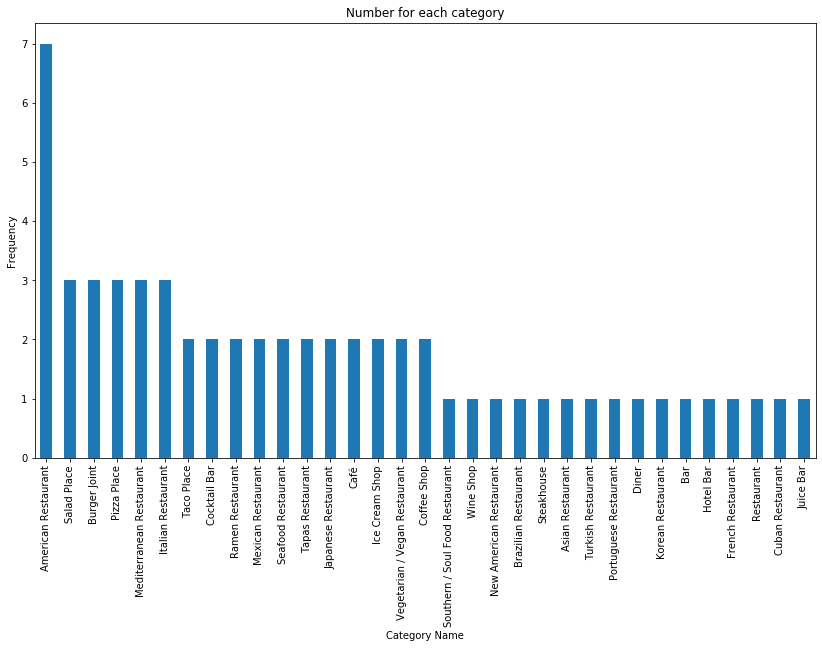

In [214]:
ax = chinatown_venues['categories'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for each category")
ax.set_xlabel("Category Name")
ax.set_ylabel("Frequency")

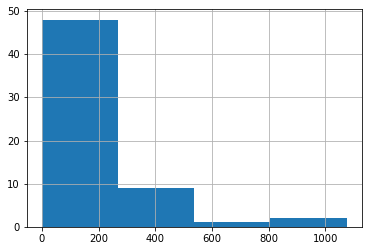

In [215]:
# let's visualize our total likes based on a histogram

import matplotlib.pyplot as plt
chinatown_venues['total likes'].hist(bins=4)
plt.show()

In [216]:
# what are the bins we want to use?
print(np.percentile(chinatown_venues['total likes'], 5))
print(np.percentile(chinatown_venues['total likes'], 25))
print(np.percentile(chinatown_venues['total likes'], 50))
print(np.percentile(chinatown_venues['total likes'], 75))
print(np.percentile(chinatown_venues['total likes'], 95))

11.75
38.5
116.0
194.5
532.3499999999993


In [217]:
# now we have our bin values so let's set them to the appropriate values
# less than 24, 24-45, 45-76, 76>
# poor, below avg, abv avg, great

poor = chinatown_venues['total likes']<=11
below_avg = chinatown_venues[(chinatown_venues['total likes']>11) & (chinatown_venues['total likes']<=38)]
abv_avg = chinatown_venues[(chinatown_venues['total likes']>38) & (chinatown_venues['total likes']<=116)]
good = chinatown_venues[(chinatown_venues['total likes']>116) & (chinatown_venues['total likes']<=194)]
great = chinatown_venues[(chinatown_venues['total likes']>195) & (chinatown_venues['total likes']<=532)]
best = chinatown_venues['total likes']>532


In [218]:
# let's set up a function that will re-categorize our restaurants based on likes

def conditions(s):
    if s['total likes']<=11:
        return 'poor'
    if s['total likes']<=34:
        return 'below average'
    if s['total likes']<=116:
        return 'above average'
    if s['total likes']<=194:
        return 'good'
    if s['total likes']<=532:
        return 'great'
    if s['total likes']>532:
        return 'best'
    
chinatown_venues['total likes_cat']=chinatown_venues.apply(conditions, axis=1)
chinatown_venues

,name,id,categories,lat,lng,total likes,total likes_cat
2,CAVA,54231977498eff43caedb3d5,Mediterranean Restaurant,38.899971,-77.022314,164,good
3,RPM Italian,575ae890498e04099a6d1c67,Italian Restaurant,38.902220,-77.020940,161,good
4,La Colombe Coffee Roasters,5648c247498e93b42e8897c8,Coffee Shop,38.901054,-77.020102,238,great
6,Nando's,4a4eb693f964a520f4ae1fe3,Portuguese Restaurant,38.900370,-77.021942,355,great
7,Dolcezza Gelato,552d5a73498e337582e351bf,Ice Cream Shop,38.900201,-77.024218,240,great
8,Taco Bamba,5ac710302b984427e9f885c7,Taco Place,38.901064,-77.022682,55,above average
9,Chaia,5c34e803dab4b1002c5c4653,Taco Place,38.901015,-77.020934,14,below average
10,BIBIBOP Asian Grill,5942c26fdec1d635b48cf514,Asian Restaurant,38.898887,-77.021876,23,below average
11,Zaytinya,3fd66200f964a520d5f11ee3,Mediterranean Restaurant,38.898811,-77.023645,1075,best
12,Legal Sea Foods,4a561b68f964a52072b41fe3,Seafood Restaurant,38.898795,-77.021853,161,good


## Lets analyze the categories based on number of restaurants of each type

Text(0, 0.5, 'Frequency')

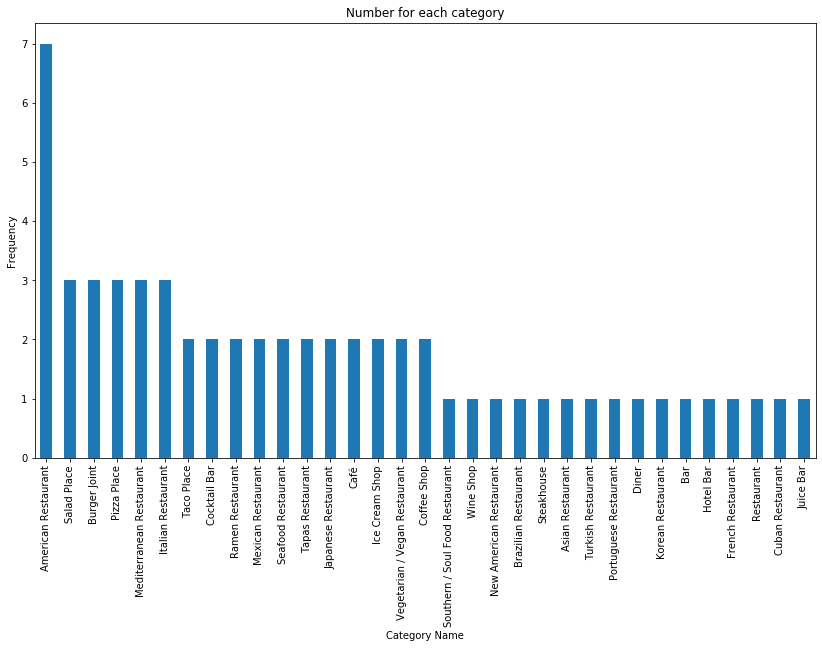

In [219]:

# let's star the process for re-categorizing the categories

ax = chinatown_venues['categories'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for each category")
ax.set_xlabel("Category Name")
ax.set_ylabel("Frequency")

In [220]:
chinatown_venues['categories'].unique()

array(['Mediterranean Restaurant', 'Italian Restaurant', 'Coffee Shop',
       'Portuguese Restaurant', 'Ice Cream Shop', 'Taco Place',
       'Asian Restaurant', 'Seafood Restaurant',
       'Vegetarian / Vegan Restaurant', 'Tapas Restaurant',
       'Ramen Restaurant', 'Salad Place', 'Burger Joint',
       'American Restaurant', 'Japanese Restaurant', 'Diner',
       'Steakhouse', 'New American Restaurant', 'Café', 'Cocktail Bar',
       'Bar', 'Brazilian Restaurant', 'French Restaurant',
       'Mexican Restaurant', 'Pizza Place', 'Cuban Restaurant',
       'Turkish Restaurant', 'Southern / Soul Food Restaurant',
       'Juice Bar', 'Restaurant', 'Hotel Bar', 'Wine Shop',
       'Korean Restaurant'], dtype=object)

In [221]:
# let's create our new categories and create a function to apply those to our existing data

american = ['American Restaurant','Restaurant','Diner','New American Restaurant','Burger Joint']
bars = ['Hotel Bar', 'Wine Shop','Cocktail Bar', 'Bar']
south_am = ['Taco Place','Brazilian Restaurant','Southern / Soul Food Restaurant','Mexican Restaurant','Cuban Restaurant']
MidEast_Asian_Food = ['Korean Restaurant','Mediterranean Restaurant','Asian Restaurant','Vegetarian / Vegan Restaurant','Ramen Restaurant','Japanese Restaurant','Tapas Restaurant']
european = [ 'Italian Restaurant','Portuguese Restaurant','Pizza Place','French Restaurant','Turkish Restaurant']
other = ['Seafood Restaurant','Salad Place','Steakhouse','Juice Bar','Ice Cream Shop','Coffee Shop','Café']

def conditions2(s):
    if s['categories'] in bars:
        return 'bars'
    if s['categories'] in other:
        return 'others'
    if s['categories'] in MidEast_Asian_Food:
        return 'Middle Eastern and Asian'
    if s['categories'] in south_am:
        return 'Mexican South American'
    if s['categories'] in european:
        return 'European'
    if s['categories'] in american:
        return 'American'

chinatown_venues['categories_new']=chinatown_venues.apply(conditions2, axis=1)

In [222]:
chinatown_venues

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new
2,CAVA,54231977498eff43caedb3d5,Mediterranean Restaurant,38.899971,-77.022314,164,good,Middle Eastern and Asian
3,RPM Italian,575ae890498e04099a6d1c67,Italian Restaurant,38.902220,-77.020940,161,good,European
4,La Colombe Coffee Roasters,5648c247498e93b42e8897c8,Coffee Shop,38.901054,-77.020102,238,great,others
6,Nando's,4a4eb693f964a520f4ae1fe3,Portuguese Restaurant,38.900370,-77.021942,355,great,European
7,Dolcezza Gelato,552d5a73498e337582e351bf,Ice Cream Shop,38.900201,-77.024218,240,great,others
8,Taco Bamba,5ac710302b984427e9f885c7,Taco Place,38.901064,-77.022682,55,above average,Mexican South American
9,Chaia,5c34e803dab4b1002c5c4653,Taco Place,38.901015,-77.020934,14,below average,Mexican South American
10,BIBIBOP Asian Grill,5942c26fdec1d635b48cf514,Asian Restaurant,38.898887,-77.021876,23,below average,Middle Eastern and Asian
11,Zaytinya,3fd66200f964a520d5f11ee3,Mediterranean Restaurant,38.898811,-77.023645,1075,best,Middle Eastern and Asian
12,Legal Sea Foods,4a561b68f964a52072b41fe3,Seafood Restaurant,38.898795,-77.021853,161,good,others


## Hot Encoding to implement clustering algorithms

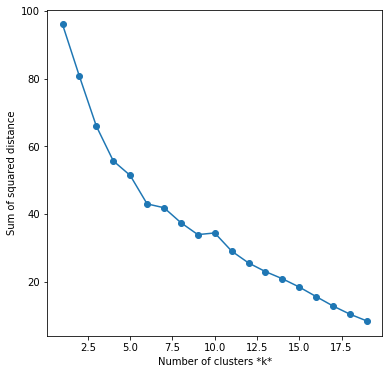

In [246]:


sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(cluster_df)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [239]:
cluster_df = chinatown_onehot.drop('Name', axis=1)

k_clusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 3, 3, 3, 0, 2, 2, 3, 1], dtype=int32)

In [240]:

chinatown_venues['label'] = kmeans.labels_
chinatown_venues.head()

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
2,CAVA,54231977498eff43caedb3d5,Mediterranean Restaurant,38.899971,-77.022314,164,good,Middle Eastern and Asian,1
3,RPM Italian,575ae890498e04099a6d1c67,Italian Restaurant,38.902220,-77.020940,161,good,European,1
4,La Colombe Coffee Roasters,5648c247498e93b42e8897c8,Coffee Shop,38.901054,-77.020102,238,great,others,3
6,Nando's,4a4eb693f964a520f4ae1fe3,Portuguese Restaurant,38.900370,-77.021942,355,great,European,3
7,Dolcezza Gelato,552d5a73498e337582e351bf,Ice Cream Shop,38.900201,-77.024218,240,great,others,3


## Plotting all the major clusters on MAP

In [241]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
sw = chinatown_venues[['lat', 'lng']].min().values.tolist()
ne = chinatown_venues[['lat', 'lng']].max().values.tolist()


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chinatown_venues['lat'], chinatown_venues['lng'], chinatown_venues['name'], chinatown_venues['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.fit_bounds([sw,ne])
map_clusters


## Cluster 1 : Above Average Restuarants 

In [242]:
chinatown_venues.loc[chinatown_venues['label']==0]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
8,Taco Bamba,5ac710302b984427e9f885c7,Taco Place,38.901064,-77.022682,55,above average,Mexican South American,0
15,Shouk,572a235c498ee06f5eaceb9d,Vegetarian / Vegan Restaurant,38.902737,-77.020600,107,above average,Middle Eastern and Asian,0
19,HipCityVeg,57599792498e1b7150fe95f1,Vegetarian / Vegan Restaurant,38.898953,-77.022145,61,above average,Middle Eastern and Asian,0
22,The Capital Burger,5aa6f0eee075507441b7a499,Burger Joint,38.903107,-77.021751,83,above average,American,0
30,Crimson Diner + Whiskey Bar,5952f04c7b2e047f4e3fdf63,Diner,38.899990,-77.020975,58,above average,American,0
33,Izakaya,580d476738fa69fff46fc06f,Japanese Restaurant,38.898577,-77.019865,39,above average,Middle Eastern and Asian,0
36,Kinship,567b3262498e1d6a13fc352c,New American Restaurant,38.903305,-77.021797,80,above average,American,0
49,Free State,586c359f5e56b4471f7a4d26,Bar,38.898380,-77.019125,41,above average,bars,0
53,Texas de Brazil,5575f88b498e6a2031ed0eef,Brazilian Restaurant,38.900900,-77.017948,49,above average,Mexican South American,0
54,Five Guys,4a50ee92f964a52044b01fe3,Burger Joint,38.899643,-77.023466,77,above average,American,0


## Cluster 2 : Good Restuarants

In [243]:
chinatown_venues.loc[chinatown_venues['label']==1]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
2,CAVA,54231977498eff43caedb3d5,Mediterranean Restaurant,38.899971,-77.022314,164,good,Middle Eastern and Asian,1
3,RPM Italian,575ae890498e04099a6d1c67,Italian Restaurant,38.902220,-77.020940,161,good,European,1
12,Legal Sea Foods,4a561b68f964a52072b41fe3,Seafood Restaurant,38.898795,-77.021853,161,good,others,1
21,CHOPT,4a8840cbf964a5208f0520e3,Salad Place,38.899251,-77.022113,137,good,others,1
28,Farmers & Distillers,57f24558498e2c8382f6adb3,American Restaurant,38.901358,-77.020206,176,good,American,1
29,Momiji,4a750244f964a52044e01fe3,Japanese Restaurant,38.899996,-77.019193,131,good,Middle Eastern and Asian,1
32,Del Frisco's Double Eagle Steakhouse,54171297498e3d2a9d876590,Steakhouse,38.900750,-77.024588,134,good,others,1
41,Capital One Café,5ba1ab18de3bbf002c709dad,Café,38.899690,-77.022013,7,poor,others,1
45,Bantam King,575b2c62498e538453bc141f,Ramen Restaurant,38.898452,-77.019117,130,good,Middle Eastern and Asian,1
55,Denson Liquor Bar,546d6c82498e1cad95af4a5e,Cocktail Bar,38.897047,-77.020107,159,good,bars,1


## Cluster 3:Middle Eastern and Asian restuarant with Best or Great Rating 

In [232]:
chinatown_venues.loc[chinatown_venues['label']==2]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
10,BIBIBOP Asian Grill,5942c26fdec1d635b48cf514,Asian Restaurant,38.898887,-77.021876,23,below average,Middle Eastern and Asian,2
11,Zaytinya,3fd66200f964a520d5f11ee3,Mediterranean Restaurant,38.898811,-77.023645,1075,best,Middle Eastern and Asian,2
16,Boqueria,5bdb1cb08fb09e002df5c82e,Tapas Restaurant,38.899416,-77.023755,18,below average,Middle Eastern and Asian,2
17,Daikaya,50905502d63e87c2d3448e35,Ramen Restaurant,38.898538,-77.019643,829,best,Middle Eastern and Asian,2
34,Fig & Olive,55781818498e506f812dda67,Mediterranean Restaurant,38.900270,-77.024530,217,great,Middle Eastern and Asian,2
86,Jaleo,4a6e4e04f964a52074d41fe3,Tapas Restaurant,38.895914,-77.022164,493,great,Middle Eastern and Asian,2


## Cluster 4: Great Restuarants

In [233]:

chinatown_venues.loc[chinatown_venues['label']==3]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
4,La Colombe Coffee Roasters,5648c247498e93b42e8897c8,Coffee Shop,38.901054,-77.020102,238,great,others,3
6,Nando's,4a4eb693f964a520f4ae1fe3,Portuguese Restaurant,38.900370,-77.021942,355,great,European,3
7,Dolcezza Gelato,552d5a73498e337582e351bf,Ice Cream Shop,38.900201,-77.024218,240,great,others,3
43,Clyde's of Gallery Place,454a14f8f964a5209e3c1fe3,American Restaurant,38.898905,-77.021783,522,great,American,3
51,A Baked Joint,5581a9a8498e9053810aa260,Café,38.902280,-77.017215,436,great,others,3
62,City Tap House Penn Quarter,528fe1a5498eba71d4957543,American Restaurant,38.901091,-77.023701,400,great,American,3
71,Rosa Mexicano,41ca0a80f964a520971e1fe3,Mexican Restaurant,38.897319,-77.021527,288,great,Mexican South American,3
78,Pi Pizzeria,4e562f4cc65be3cea4621714,Pizza Place,38.897168,-77.024658,478,great,European,3
79,Wiseguy NY Pizza,509db390e4b01b9e4932c44f,Pizza Place,38.899608,-77.015963,300,great,European,3
80,Cuba Libre,4bd22974a8b3a593474d675f,Cuban Restaurant,38.899974,-77.023736,283,great,Mexican South American,3


## Cluster 5: Below Average American Restuarant

In [234]:

chinatown_venues.loc[chinatown_venues['label']==4]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
9,Chaia,5c34e803dab4b1002c5c4653,Taco Place,38.901015,-77.020934,14,below average,Mexican South American,4
35,Acela Club,4baaaeb4f964a5206f7f3ae3,American Restaurant,38.898102,-77.020897,23,below average,American,4
40,Rita's Italian Ice & Frozen Custard,4c6daf4865eda09341614fd0,Ice Cream Shop,38.899659,-77.020675,25,below average,others,4
47,Morris,5a72342e6c08d128d729c78b,Cocktail Bar,38.903482,-77.021937,21,below average,bars,4
65,Renaissance Downtown Concierge Lounge,4e89a1a39a52f9bbd0e733dd,American Restaurant,38.901774,-77.023538,26,below average,American,4
75,Poca Madre,5b2c4e88fe63bd002c3bd625,Mexican Restaurant,38.900970,-77.022739,12,below average,Mexican South American,4
76,Shake Shack,51c22f467dd2142513d69372,Burger Joint,38.896995,-77.023762,729,best,American,4
91,Estuary,5c848408fd16bb00395f63d1,Restaurant,38.901258,-77.025806,12,below average,American,4
92,Busboys and Poets,5b8f5ad8464d65002c541ae9,American Restaurant,38.902457,-77.018107,23,below average,American,4
